<a href="https://colab.research.google.com/github/Nova3012k/Regression-Methods-Machine-Learning-/blob/main/Logistic_Regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression: Diagnóstico Médico

## Fundamentos de la técnica

La Regresión Logística es un algoritmo de Machine Learning diseñado para responder preguntas de Sí o No.Aunque su nombre dice "Regresión", en realidad se utiliza para tareas de Clasificación. Su objetivo principal no es predecir un número exacto (como el precio de una casa), sino estimar la probabilidad de que algo pertenezca a una categoría específica.

Sus 3 características clave son:
1. Clasificación Binaria: Funciona separando los datos en dos clases. En este proyecto: Maligno (1) vs. Benigno (0).

2. Salida Probabilística: El resultado del modelo siempre es un número entre 0 y 1. Por ejemplo: 0.85 (significa un 85% de probabilidad de ser Maligno).

3. La Frontera de Decisión (Threshold): Para tomar la decisión final, el modelo usa un umbral (generalmente 0.5).
- Si la probabilidad es mayor a 0.5 $\rightarrow$ Predice Maligno.
- Si la probabilidad es menor a 0.5 $\rightarrow$ Predice Benigno.

## Modelo Matematico
El modelo matemático de la Regresión Logística consta de tres pasos secuenciales para transformar los datos clínicos en una predicción de cáncer.

**Paso 1:** La Función Lineal (El "Puntaje")Primero, el modelo asigna un peso (importancia) a cada característica médica (radio, textura, etc.) y calcula una suma ponderada. Esto es idéntico a la regresión lineal.$$z = w_1x_1 + w_2x_2 + ... + w_nx_n + b$$

- $z$: Es el resultado lineal (Logit). Puede ser cualquier número (ej. -150 o +500).

- $w$ (Pesos): Qué tan importante es esa variable para decidir si es cáncer.$x$ (Entradas): Los valores del paciente (radio, textura, etc.).

- $b$ (Sesgo): Un ajuste base del modelo.


**Paso 2:** La Función Sigmoide (La Transformación)Como $z$ puede ser un número infinito, no nos sirve como probabilidad. Para solucionarlo, pasamos $z$ por la Función Sigmoide, que comprime cualquier valor para que quede estrictamente entre 0 y 1.La fórmula es:$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

- Si $z$ es muy grande (positivo) $\rightarrow$ la probabilidad se acerca a 1 (Maligno).

- Si $z$ es muy pequeño (negativo) $\rightarrow$ la probabilidad se acerca a 0 (Benigno).

**Paso 3:** Función de Costo (Log Loss)Para aprender los mejores pesos ($w$), el modelo no usa el error cuadrático. Utiliza la Pérdida Logarítmica (Log Loss). Esta fórmula penaliza fuertemente al modelo si dice con seguridad que un paciente está sano (probabilidad $\approx 0$) cuando en realidad tiene cáncer ($y=1$).$$J(w) = - \frac{1}{m} \sum_{i=1}^{m} [y^{(i)}\log(\hat{y}^{(i)}) + (1-y^{(i)})\log(1-\hat{y}^{(i)})]$$Donde el objetivo del entrenamiento es minimizar $J(w)$.

## 1.3 Descripción de la librería y clases (Python)

Utilizaremos el ecosistema Scikit-Learn (sklearn) para la implementación del modelo.

sklearn.linear_model.LogisticRegression:

- penalty: Especifica la norma utilizada en la penalización (L1 o L2). Sirve para reducir la complejidad del modelo y evitar el sobreajuste.

- fit(X, y): Método que ejecuta el algoritmo de optimización (como el Descenso de Gradiente) para encontrar los mejores pesos.

- predict_proba(X): Método crucial que devuelve las probabilidades reales (ej. 0.85) antes de convertirlas a 0 o 1.

- StandardScaler: Estandariza las características eliminando la media y escalando a la varianza de la unidad. Es vital en regresión logística porque los coeficientes se interpretan según la magnitud de las variables.

- seaborn & matplotlib: Librerías utilizadas para la visualización de datos (Heatmaps y Scatter plots).

Dimensiones del dataset: (569, 31)

Verificación de valores nulos:
0


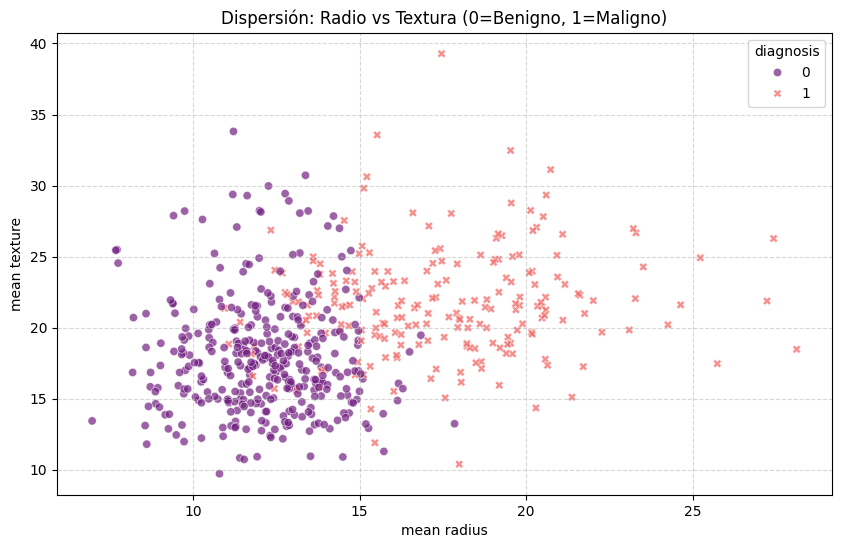

In [1]:
# 1.4 Pipeline

# --- Importación de Librerías ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# --- Preprocesamiento ---

# Cargar dataset de Cáncer de Mama (Wisconsin)
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['diagnosis'] = data.target

# Nota sobre el target: en sklearn para este dataset, 0 = Maligno, 1 = Benigno.
# Para hacerlo más intuitivo, invertiremos los valores: 1 = Maligno (Caso positivo/riesgo), 0 = Benigno.
df['diagnosis'] = df['diagnosis'].apply(lambda x: 0 if x == 1 else 1)

print(f"Dimensiones del dataset: {df.shape}")
print("\nVerificación de valores nulos:")
print(df.isnull().sum().sum())  # Debería ser 0

# Despliegue del Gráfico de Dispersión (Scatter Chart)
# Visualizaremos la relación entre el 'Radio Medio' y la 'Textura Media'
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='mean radius',
    y='mean texture',
    hue='diagnosis',
    style='diagnosis',
    palette='magma',
    alpha=0.7
)
plt.title('Dispersión: Radio vs Textura (0=Benigno, 1=Maligno)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Este gráfico confirma que existe una correlación visible entre el tamaño y la textura del tumor con su diagnóstico. Al ver que los casos benignos (morados) se agrupan en valores bajos y los malignos (rosas) en valores altos, confirmamos que la Regresión Logística podrá trazar una línea (frontera de decisión) entre ambos grupos para clasificarlos con alta precisión

## Feature Engineering

En esta etapa preparamos las variables para maximizar el rendimiento del modelo.

1. Selección de Variables: El dataset contiene 30 características. Para un modelo logístico, usar demasiadas variables correlacionadas (multicolinealidad) puede afectar la interpretación de los coeficientes. Sin embargo, gracias a la Regularización L2 (activada por defecto en sklearn), el modelo puede manejar esto penalizando los pesos. Usaremos todas las variables para maximizar la información.

2. Escalamiento (Normalización): Las características varían en rangos muy diferentes (el área puede ser 1000, la suavidad 0.08). Sin escalamiento, la característica con números más grandes dominaría el modelo. Usaremos StandardScaler para transformar los datos a una distribución con media 0 y desviación estándar 1.

## Entrenamiento y Función de Predicción

In [2]:
# --- Feature Engineering ---

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# División 75% train, 25% test
# USO: Aquí sklearn divide los datos automáticamente
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

# Escalamiento
# USO: Aquí la librería calcula el promedio y desviación estándar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamiento
# USO 1: Creas el "cerebro" vacío (la instancia de la clase)
modelo_lr = LogisticRegression(solver='liblinear', random_state=101)
# USO 2:(.fit)
# Aquí es donde sklearn usa la matemática (Sigmoide, Log-Loss) para aprender
modelo_lr.fit(X_train_scaled, y_train)

# --- Prediction ---

def predecir_diagnostico(patron_entrada):
    """
    Recibe una lista con los 30 valores de las características celulares.
    Retorna la clase y la probabilidad de malignidad.
    """
    # Convertir a array y escalar
    patron_array = np.array(patron_entrada).reshape(1, -1)
    patron_scaled = scaler.transform(patron_array)

    # Predicción
    prediccion_clase = modelo_lr.predict(patron_scaled)[0]
    probabilidad = modelo_lr.predict_proba(patron_scaled)[0][1] # Probabilidad de ser clase 1

    etiqueta = "MALIGNO (Riesgo)" if prediccion_clase == 1 else "BENIGNO (Sano)"

    print(f"--- Resultado del Análisis ---")
    print(f"Diagnóstico: {etiqueta}")
    print(f"Probabilidad estimada de malignidad: {probabilidad*100:.2f}%")
    return prediccion_clase

# Prueba con un dato real del conjunto de test (ej. el primer paciente del test)
# Nota: Extraemos los valores crudos (sin escalar) para simular un dato nuevo
paciente_prueba = X_test.iloc[0].values
predecir_diagnostico(paciente_prueba)

--- Resultado del Análisis ---
Diagnóstico: BENIGNO (Sano)
Probabilidad estimada de malignidad: 0.39%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


np.int64(0)

## Model Evaluation: Interpretación de Métricas

1. Matriz de Confusión: Es fundamental en medicina. No es lo mismo decirle a una persona sana que está enferma (Falso Positivo) que decirle a una persona enferma que está sana (Falso Negativo).

- Falso Negativo (Error Tipo II): El error más peligroso en este contexto. El paciente tiene cáncer, pero el modelo dice que no.

$$Accuracy = \frac{141}{143} = 0.986 \rightarrow \mathbf{98.6\%}$$

- Accuracy (Exactitud):Representa el porcentaje total de predicciones correctas.Fórmula: $(TP + TN) / Total$En nuestro caso: El modelo clasificó correctamente al 98.6% de los pacientes. Esto nos indica que el modelo es muy robusto de manera global, ya que casi no comete errores ni con los sanos ni con los enfermos.

$$Accuracy = \frac{\text{Verdaderos Negativos (87)} + \text{Verdaderos Positivos (54)}}{\text{Total de Pacientes (143)}}$$

3. Precision y Recall (Opcional pero recomendado): En este contexto, el Recall (Sensibilidad) es vital: ¿De todos los casos que realmente eran cáncer, cuántos detectamos?



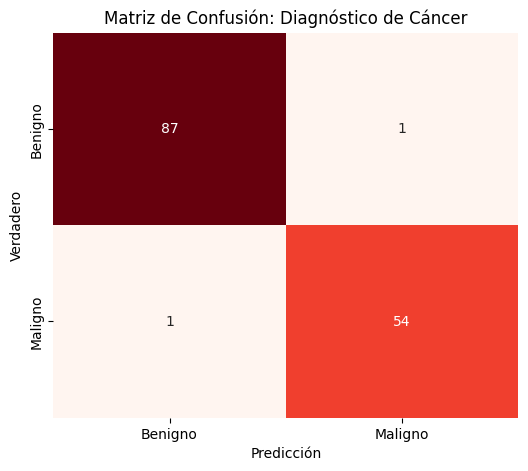

Accuracy: 0.9860

Reporte Detallado:
              precision    recall  f1-score   support

     Benigno       0.99      0.99      0.99        88
     Maligno       0.98      0.98      0.98        55

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



In [3]:
# --- Model Evaluation ---

y_pred = modelo_lr.predict(X_test_scaled)

# 1. Matriz de Confusión Visual
# USO: Calcular la matriz y el accuracy
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['Benigno', 'Maligno'],
            yticklabels=['Benigno', 'Maligno'])
plt.title('Matriz de Confusión: Diagnóstico de Cáncer')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()

# 2. Métricas Numéricas
# USO: Calcular la matriz y el accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("\nReporte Detallado:")
print(classification_report(y_test, y_pred, target_names=['Benigno', 'Maligno']))

## Referencias Bibliográficas (APA 7)
Géron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed.). O'Reilly Media.

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An Introduction to Statistical Learning: with Applications in R. Springer.

Scikit-learn developers. (2023). User Guide: Logistic regression. Scikit-learn: Machine Learning in Python. https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression